In [1]:
from tensorflow.keras import layers, models, applications
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# @title 데이터준비

import gdown, zipfile, os

file_id = '1hZEUQJqxv60MmVNGigf_ig9mdkQFPLIm'
output = 'file.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

output_dir = 'cloud'
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(output, 'r') as z:
  z.extractall(output_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1hZEUQJqxv60MmVNGigf_ig9mdkQFPLIm
From (redirected): https://drive.google.com/uc?id=1hZEUQJqxv60MmVNGigf_ig9mdkQFPLIm&confirm=t&uuid=02ff6e65-109a-4853-9c7e-214f033f774b
To: /content/file.zip
100%|██████████| 187M/187M [00:05<00:00, 33.1MB/s]


In [3]:
#@title DataLoad
from sklearn.model_selection import train_test_split
import numpy as np

def load_data(base_dir='cloud'):
  images = []
  labels = []
  class_names = []

  for class_name in os.listdir(base_dir):
    class_name_path = os.path.join(base_dir, class_name)

    # 디렉토리인 경우만
    if os.path.isdir(class_name_path):
      for image_name in os.listdir(class_name_path):
        image_path = os.path.join(class_name_path, image_name)
        images.append(image_path)
        labels.append(class_name)

  return np.array(images), np.array(labels)

images, labels = load_data()
print(images.shape, labels.shape)
print(np.unique(labels))


(13104,) (13104,)
['Ac' 'As' 'Cb' 'Cc' 'Ci' 'Cs' 'Ct' 'Cu' 'Ns' 'Sc' 'St']


In [4]:
# @title 클래스 정의, 시퀀스 생성

from re import S
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import numpy as np
import cv2

BATCH_SIZE = 64
IMAGE_SIZE = 224

class CloudResnet(Sequence):
    def __init__(self, images, labels, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, augmentor=None, shuffle=False, preprocess_function=None):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        self.preprocess_function = preprocess_function
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end] if self.labels is not None else None

        resized_images = np.zeros((len(batch_images), self.image_size, self.image_size, 3), dtype=np.float32)
        for i, image_path in enumerate(batch_images):
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Unable to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            if self.preprocess_function is not None:
                image = self.preprocess_function(image)
            resized_images[i] = image

        return (resized_images, batch_labels) if self.labels is not None else resized_images

    def on_epoch_end(self):
        if self.shuffle:
            self.images, self.labels = shuffle(self.images, self.labels)



In [5]:
# @title 모델 생성 함수 정의

from tensorflow.keras.models import Model

def create_pretrainded_resnet():
    base_model = applications.ResNet50(input_shape=(224, 224, 3), include_top=False)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(500, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(11, activation='softmax')(x)

    model = Model(inputs = base_model.input, outputs = output)
    return model



In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder

tr_images, val_images, tr_labels, val_labels = \
  train_test_split(images, labels, test_size=0.2, random_state=0)

# one-hot encoding ->label encoding
label_encoder = LabelEncoder()
tr_labels_encoded = label_encoder.fit_transform(tr_labels)
val_labels_encoded = label_encoder.transform(val_labels)

tr_images.shape, tr_labels.shape, val_images.shape, val_labels.shape

((10483,), (10483,), (2621,), (2621,))

In [7]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# 학습/검증/평가용 Sequence 객체 준비
tr_seq = CloudResnet(tr_images, tr_labels_encoded, preprocess_function=preprocess_input, shuffle=True)
val_seq = CloudResnet(val_images, val_labels_encoded, preprocess_function=preprocess_input, shuffle=False)

# test_seq = CloudResnet(test_images, test_labels, preprocess_function=preprocess_input, shuffle=False)


In [8]:
# @title 모델 생성

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


model = create_pretrainded_resnet()

model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

tr_seq = CloudResnet(tr_images, tr_labels_encoded, preprocess_function=preprocess_input, shuffle=True)
val_seq = CloudResnet(val_images, val_labels_encoded, preprocess_function=preprocess_input, shuffle=False)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# 콜백 정의
early_stopping_cb = EarlyStopping(patience=6, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# 학습
history = model.fit(
    tr_seq,
    epochs=30,
    validation_data=val_seq,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 210s 859ms/step - accuracy: 0.3034 - loss: 2.3463 - val_accuracy: 0.2820 - val_loss: 3.0883 - learning_rate: 0.0010
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 598ms/step - accuracy: 0.4414 - loss: 1.6048 - val_accuracy: 0.3792 - val_loss: 1.7935 - learning_rate: 0.0010
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 95s 575ms/step - accuracy: 0.5359 - loss: 1.3629 - val_accuracy: 0.4968 - val_loss: 1.4275 - learning_rate: 0.0010
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 99s 600ms/step - accuracy: 0.5995 - loss: 1.1402 - val_accuracy: 0.5696 - val_loss: 1.2638 - learning_rate: 0.0010
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 579ms/step - accuracy: 0.6646 - loss: 0.9445 - val_accuracy: 0.5189 - val_loss: 1.4543 - learning_rate: 0.0010
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 142s 576ms/step - accuracy: 0.7208 - loss: 0.7922 - val_accuracy: 0.5406 - val_loss: 1.5233 - learning_rate: 0.0010
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 96s 581ms/step - accuracy: 0.7827 - los

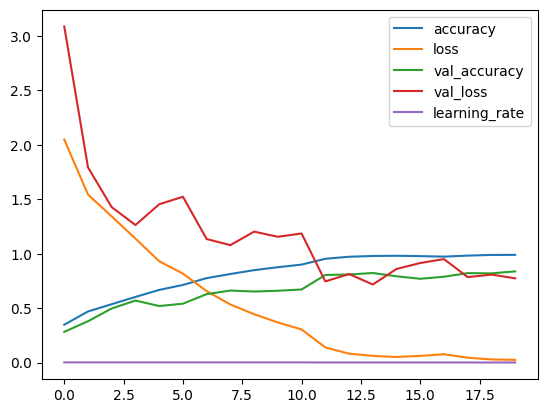

In [10]:

# 학습 결과 시각화
pd.DataFrame(history.history).plot()
plt.show()


In [13]:
# 평가

loss, accuracy = model.evaluate(val_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8213 - loss: 0.7279
loss: 0.7168, accuracy: 0.8226


In [18]:
# @title 모델 예측

# 테스트 데이터 로드
test_images, test_labels = load_data(base_dir='path_to_test_data')
test_labels_encoded = label_encoder.transform(test_labels)

# 테스트 데이터 시퀀스 생성
test_seq = CloudResnet(test_images, test_labels_encoded, preprocess_function=preprocess_input, shuffle=False)

# 모델 예측
pred_proba = model.predict(test_seq)  # 시퀀스 객체로 예측
print(pred_proba.shape)

# 클래스 이름 정의
class_names = np.array(['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St'])

# 결과 시각화 함수
def show_images(images, labels, ncols=8):
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 6))
    for i in range(ncols):
        image = cv2.imread(images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image)  # 이미지 출력
        class_name = class_names[labels[i]]
        ax[i].set_title(class_name)
    plt.show()

# 예측 및 출력
pred = np.argmax(pred_proba, axis=1)
for i in range(10):
    print(f'{i} : {class_names[pred[i]]}')

# 실제와 예측 비교
show_images(test_images[:10], test_labels_encoded[:10])  # 실제 레이블
show_images(test_images[:10], pred[:10])  # 예측 레이블


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_test_data'

In [14]:
# 모델 저장
model.save('sky_mood_resnet.keras')